In [38]:
import pandas as pd
import numpy as np
import warnings
from xgboost import XGBRegressor
from utils import utils_gn, utils_sevsn, utils_noah, utils_models
import importlib
importlib.reload(utils_gn)
importlib.reload(utils_sevsn)
importlib.reload(utils_noah)
importlib.reload(utils_models)
warnings.filterwarnings('ignore')

In [39]:
# read the data
df_raw = (utils_gn.read_data('severson_all.pkl')).drop('cycle_life', axis=1).join(utils_gn.read_data('noah_all.pkl'))
df = df_raw.copy()
df.head()

,mean_Q_100_10,log_mean_Q_100_10,var_Q_100_10,log_var_Q_100_10,min_Q_100_10,log_min_Q_100_10,skew_Q_100_10,log_skew_Q_100_10,kurt_Q_100_10,log_kurt_Q_100_10,...,dVdQpeak_maxmag_di_y_100m0,dVdQpeak_maxmag_di_y_diff,dVdQpeak_maxarea_di_y_0,dVdQpeak_maxarea_di_y_50,dVdQpeak_maxarea_di_y_100,dVdQpeak_maxarea_di_y_100m0,dVdQpeak_maxarea_di_y_diff,dSOHdCycCyc1,dSOHdCycCyc100,cycle_life
b1c0,-0.002873,-2.541602,0.000010,-5.014861,-0.008460,-2.072648,-0.532058,-0.274041,1.651688,0.217928,...,-0.005282,0.003144,-79.299389,-75.009448,-68.133388,11.166000,2.586119,0.000388,-0.000031,1851.0
b1c1,-0.004100,-2.387257,0.000010,-5.013960,-0.011004,-1.958457,-0.429375,-0.367163,1.970884,0.294661,...,0.001686,0.000501,-75.511329,-73.411862,-60.405989,15.105340,10.906407,0.000396,-0.000019,2159.0
b1c2,-0.004487,-2.348070,0.000018,-4.737000,-0.017216,-1.764058,-1.080194,0.033502,3.348637,0.524868,...,-0.005399,0.004043,-76.601709,-73.345940,-65.414446,11.187263,4.675725,0.000312,-0.000013,2236.0
b1c3,-0.007456,-2.127507,0.000036,-4.442613,-0.018961,-1.722149,-0.439050,-0.357486,1.904584,0.279800,...,-0.002219,0.012165,-80.446334,-67.731448,-55.749502,24.696832,-0.732940,0.000353,-0.000013,1433.0
b1c4,-0.005750,-2.240332,0.000023,-4.647744,-0.013958,-1.855177,-0.362548,-0.440634,1.666169,0.221719,...,0.002736,0.001597,-75.575598,-65.232594,-55.730088,19.845510,-0.840498,0.000347,-0.000030,1708.0


In [40]:
df.index

Index(['b1c0', 'b1c1', 'b1c2', 'b1c3', 'b1c4', 'b1c5', 'b1c6', 'b1c7', 'b1c9',
       'b1c11',
       ...
       'b3c33', 'b3c34', 'b3c35', 'b3c36', 'b3c40', 'b3c41', 'b3c42', 'b3c43',
       'b3c44', 'b3c45'],
      dtype='object', length=124)

In [41]:
df.columns

Index(['mean_Q_100_10', 'log_mean_Q_100_10', 'var_Q_100_10',
       'log_var_Q_100_10', 'min_Q_100_10', 'log_min_Q_100_10', 'skew_Q_100_10',
       'log_skew_Q_100_10', 'kurt_Q_100_10', 'log_kurt_Q_100_10',
       ...
       'dVdQpeak_maxmag_di_y_100m0', 'dVdQpeak_maxmag_di_y_diff',
       'dVdQpeak_maxarea_di_y_0', 'dVdQpeak_maxarea_di_y_50',
       'dVdQpeak_maxarea_di_y_100', 'dVdQpeak_maxarea_di_y_100m0',
       'dVdQpeak_maxarea_di_y_diff', 'dSOHdCycCyc1', 'dSOHdCycCyc100',
       'cycle_life'],
      dtype='object', length=245)

In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 124 entries, b1c0 to b3c45
Columns: 245 entries, mean_Q_100_10 to cycle_life
dtypes: float64(245)
memory usage: 242.4+ KB


In [43]:
df.describe()

,mean_Q_100_10,log_mean_Q_100_10,var_Q_100_10,log_var_Q_100_10,min_Q_100_10,log_min_Q_100_10,skew_Q_100_10,log_skew_Q_100_10,kurt_Q_100_10,log_kurt_Q_100_10,...,dVdQpeak_maxmag_di_y_100m0,dVdQpeak_maxmag_di_y_diff,dVdQpeak_maxarea_di_y_0,dVdQpeak_maxarea_di_y_50,dVdQpeak_maxarea_di_y_100,dVdQpeak_maxarea_di_y_100m0,dVdQpeak_maxarea_di_y_diff,dSOHdCycCyc1,dSOHdCycCyc100,cycle_life
count,124.000000,124.000000,124.000000,124.000000,124.000000,124.000000,124.000000,124.000000,124.000000,124.000000,...,124.000000,124.000000,124.000000,124.000000,124.000000,124.000000,124.000000,124.000000,124.000000,124.000000
mean,-0.018901,-1.795793,0.000223,-3.835354,-0.040760,-1.440500,-0.103301,-0.777828,1.857125,0.261912,...,-0.000860,0.006225,-86.421878,-61.174991,-46.747626,40.011316,-11.308809,0.000265,-0.000069,807.241935
std,0.011347,0.270904,0.000262,0.411134,0.020373,0.217995,0.330102,0.425974,0.454478,0.067593,...,0.046542,0.046324,11.467643,12.863652,6.312352,9.989366,20.046688,0.000136,0.000137,364.359118
min,-0.077684,-3.105396,0.000010,-5.014861,-0.138026,-2.251053,-1.080194,-2.337813,1.612805,0.207582,...,-0.040421,-0.052170,-112.994264,-88.677648,-69.014721,0.491715,-85.815278,-0.000126,-0.001108,170.000000
25%,-0.024233,-1.950487,0.000077,-4.114970,-0.052091,-1.573442,-0.285918,-0.976312,1.710361,0.233088,...,-0.008152,-0.002622,-92.562247,-71.707141,-48.543997,36.915481,-26.371329,0.000190,-0.000065,525.750000
50%,-0.017671,-1.752752,0.000168,-3.775169,-0.038753,-1.411715,-0.141639,-0.713148,1.761561,0.245898,...,-0.005461,0.001079,-86.660594,-59.687399,-44.930027,41.479825,-6.326848,0.000246,-0.000038,743.000000
75%,-0.011208,-1.615590,0.000298,-3.526121,-0.026703,-1.283235,-0.001193,-0.472983,1.866319,0.270984,...,-0.002174,0.005336,-82.555981,-50.581414,-42.971080,46.361411,4.678101,0.000336,-0.000025,945.500000
max,0.000785,-1.109668,0.001875,-2.726901,-0.005610,-0.860038,1.986572,0.298104,5.920243,0.772340,...,0.491715,0.491715,0.491715,-21.537204,-30.971796,61.613879,23.552556,0.000990,0.000211,2236.000000


In [44]:
# prune cells with more than 1250 cycle life
df = df[df['cycle_life'] <= 1250]
df.index

Index(['b1c5', 'b1c6', 'b1c7', 'b1c9', 'b1c11', 'b1c14', 'b1c15', 'b1c16',
       'b1c17', 'b1c18',
       ...
       'b3c29', 'b3c30', 'b3c31', 'b3c34', 'b3c35', 'b3c36', 'b3c40', 'b3c41',
       'b3c43', 'b3c44'],
      dtype='object', length=113)

In [45]:
# define parameters for model pipeline
estimator = XGBRegressor()
param_grid = {"n_estimators": [100, 200, 300, 400, 500],
            "max_depth": [2, 3, 4, 5],
            "min_samples_split": [2, 3, 4, 5],
            "learning_rate": [0.01, 0.1, 1.0]}
algo = utils_models.fit_tree_based_regression
fname = 'xgb'
title = 'Extreme Gradient Boosting'

0 features removed from a total of 244
0 features removed from a total of 244
Tree-based regression has started...
Tree-based regression has ended after 0.75 seconds
------------------
Model metrics:
------------------
Train:
{'MAE': 5.254085625542535,
 'MAPE': 0.008039565345710032,
 'MSE': 45.23558538174257,
 'R2 score': 0.9990087627900213,
 'RMSE': 6.725740508058764}
Test:
{'MAE': 54.589686518130094,
 'MAPE': 0.08520321828309194,
 'MSE': 4849.680598625033,
 'R2 score': 0.9113793905291402,
 'RMSE': 69.63964817993434}


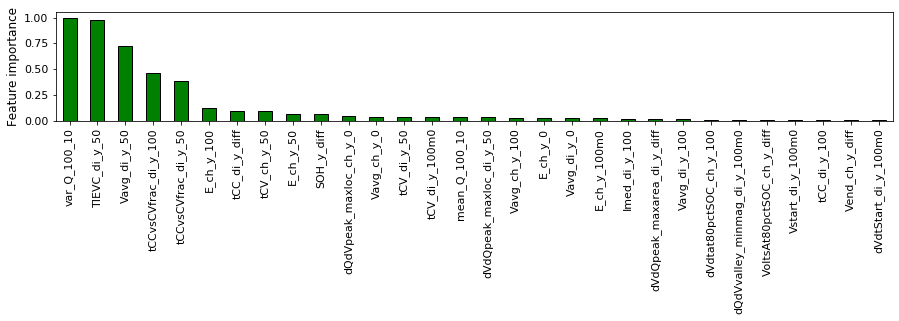

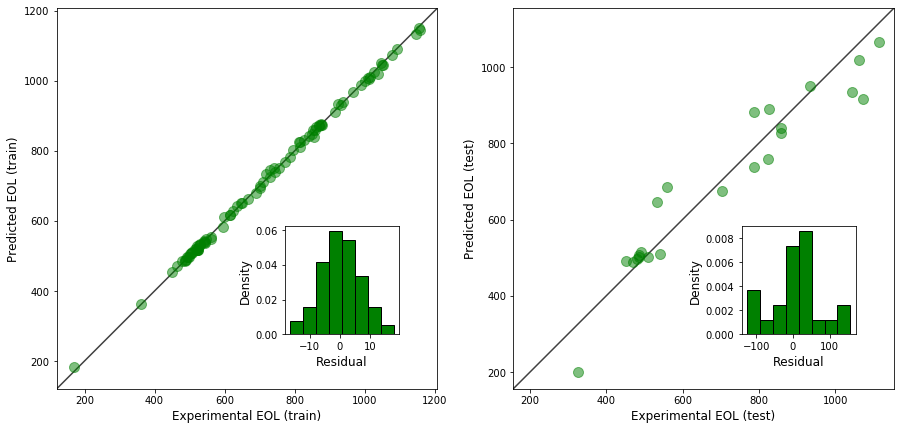

25 features removed from a total of 244
25 features removed from a total of 244
Tree-based regression has started...
Tree-based regression has ended after 0.75 seconds
------------------
Model metrics:
------------------
Train:
{'MAE': 6.297145758734809,
 'MAPE': 0.009597434826379155,
 'MSE': 62.78415261801177,
 'R2 score': 0.9986242249824608,
 'RMSE': 7.923645159774115}
Test:
{'MAE': 56.44326516856318,
 'MAPE': 0.08676612189536786,
 'MSE': 5428.104585629402,
 'R2 score': 0.900809563255273,
 'RMSE': 73.67567159944592}


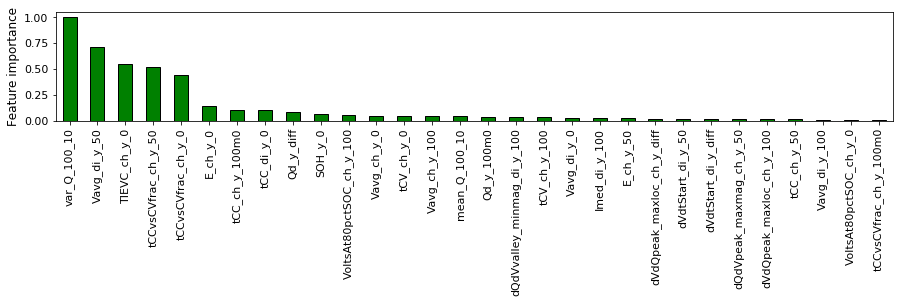

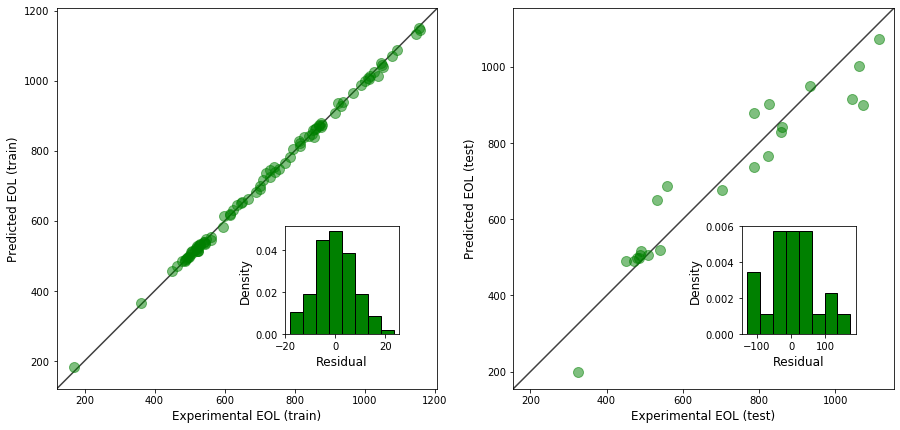

49 features removed from a total of 244
49 features removed from a total of 244
Tree-based regression has started...
Tree-based regression has ended after 0.71 seconds
------------------
Model metrics:
------------------
Train:
{'MAE': 6.627901713053386,
 'MAPE': 0.009804966010050835,
 'MSE': 71.79957138451282,
 'R2 score': 0.9984266721384005,
 'RMSE': 8.47346277412681}
Test:
{'MAE': 45.85030331818954,
 'MAPE': 0.07002579680924845,
 'MSE': 3639.7011429203835,
 'R2 score': 0.9334899428904991,
 'RMSE': 60.32993571122369}


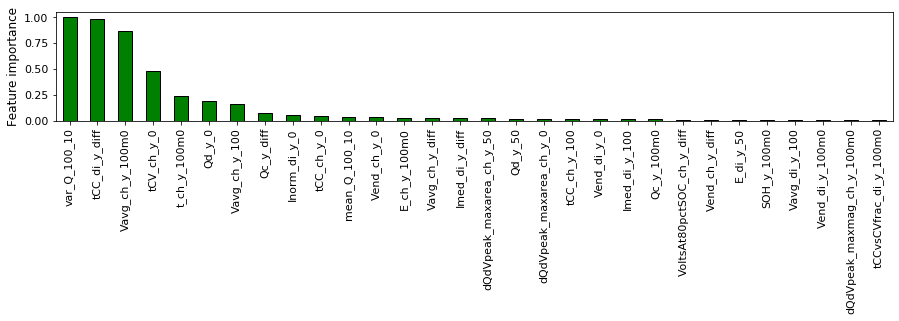

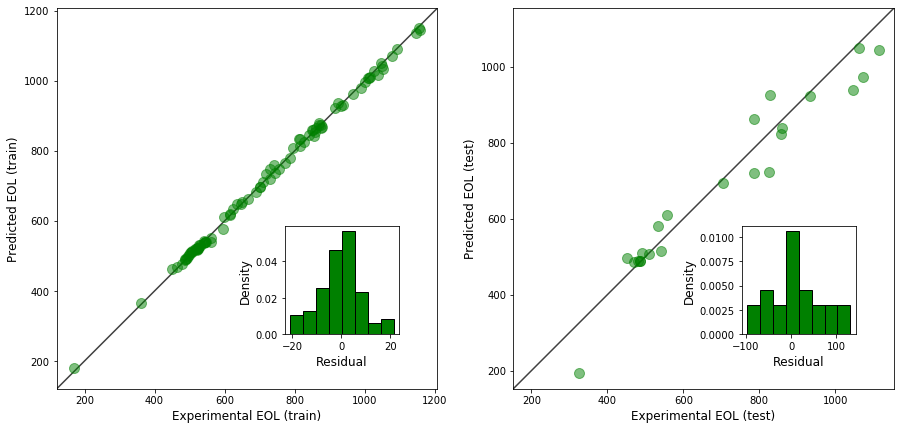

74 features removed from a total of 244
74 features removed from a total of 244
Tree-based regression has started...
Tree-based regression has ended after 0.71 seconds
------------------
Model metrics:
------------------
Train:
{'MAE': 7.18549567328559,
 'MAPE': 0.010795570966339813,
 'MSE': 87.39959272910944,
 'R2 score': 0.9980848323787792,
 'RMSE': 9.348774931995607}
Test:
{'MAE': 49.5200659710428,
 'MAPE': 0.07550662877632218,
 'MSE': 4091.584881459201,
 'R2 score': 0.9252324480916386,
 'RMSE': 63.965497586270686}


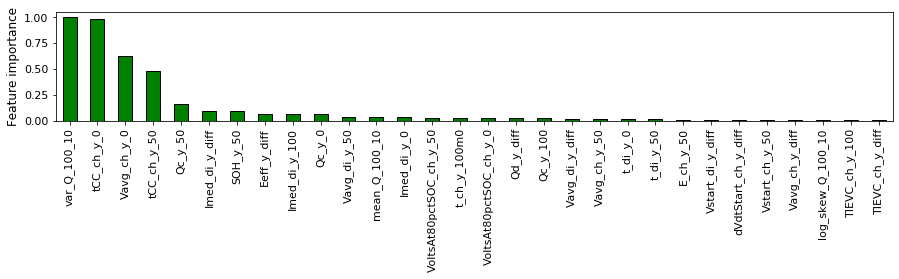

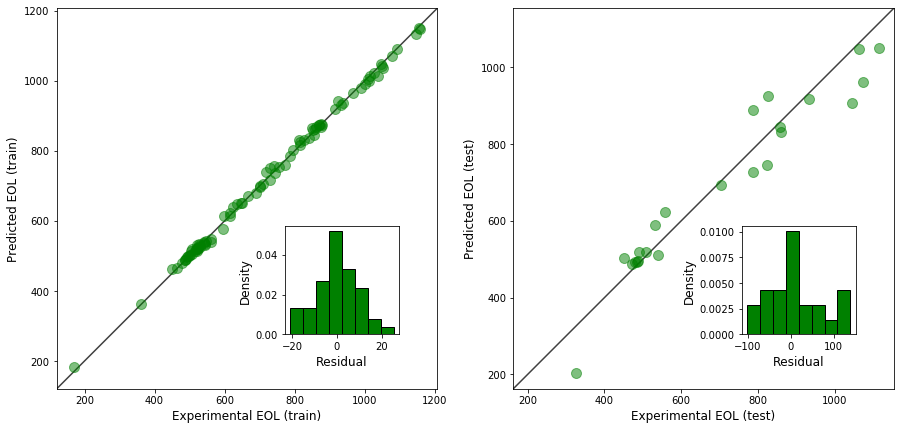

98 features removed from a total of 244
98 features removed from a total of 244
Tree-based regression has started...
Tree-based regression has ended after 2.15 seconds
------------------
Model metrics:
------------------
Train:
{'MAE': 0.18196021185980904,
 'MAPE': 0.0002711257732690896,
 'MSE': 0.05270517015467501,
 'R2 score': 0.9999988450834586,
 'RMSE': 0.22957606616255757}
Test:
{'MAE': 42.30781820546026,
 'MAPE': 0.06708821037347645,
 'MSE': 3213.5507442096105,
 'R2 score': 0.941277199657616,
 'RMSE': 56.68818875400422}


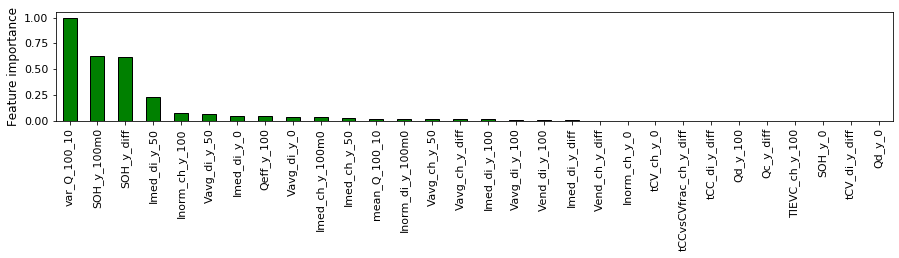

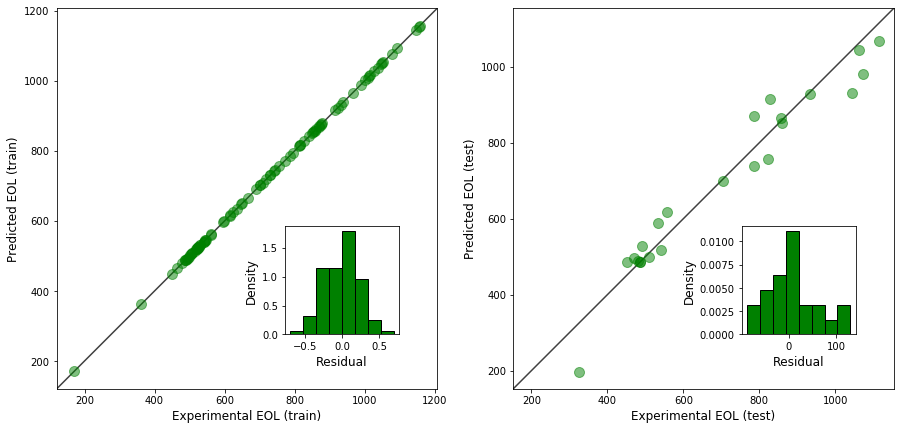

122 features removed from a total of 244
122 features removed from a total of 244
Tree-based regression has started...
Tree-based regression has ended after 0.68 seconds
------------------
Model metrics:
------------------
Train:
{'MAE': 8.212809583875869,
 'MAPE': 0.012412540262188344,
 'MSE': 108.80327470206345,
 'R2 score': 0.9976158183089247,
 'RMSE': 10.430880821007564}
Test:
{'MAE': 46.73789314601732,
 'MAPE': 0.07157825113930084,
 'MSE': 4046.3447058258434,
 'R2 score': 0.9260591441710327,
 'RMSE': 63.61088512059743}


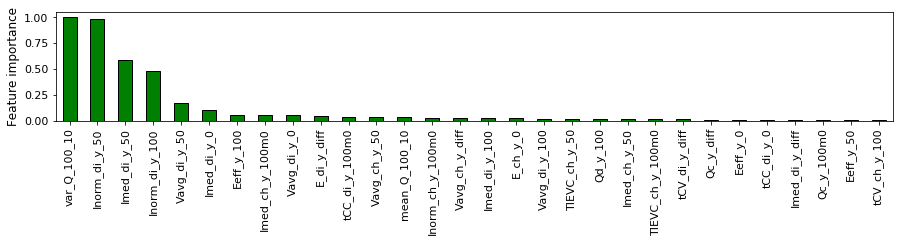

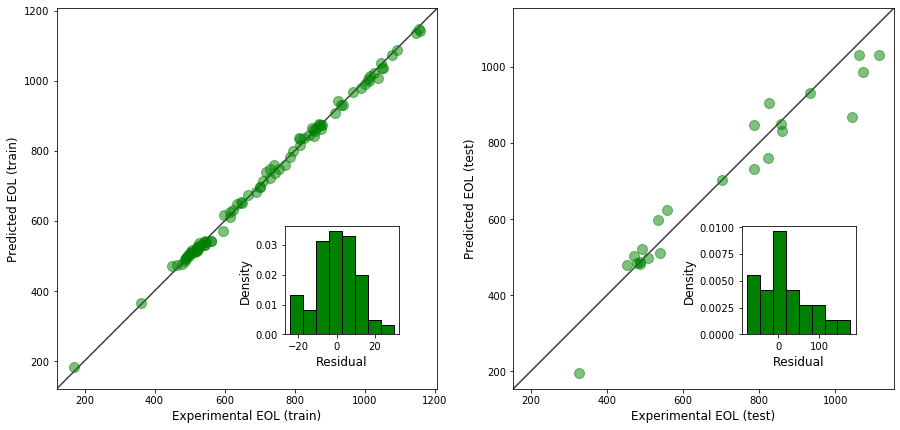

147 features removed from a total of 244
147 features removed from a total of 244
Tree-based regression has started...
Tree-based regression has ended after 0.67 seconds
------------------
Model metrics:
------------------
Train:
{'MAE': 8.508964538574219,
 'MAPE': 0.012976822765007223,
 'MSE': 127.40412577224326,
 'R2 score': 0.9972082220423474,
 'RMSE': 11.287343610090165}
Test:
{'MAE': 44.91185461956522,
 'MAPE': 0.06916280485599297,
 'MSE': 3617.498063691932,
 'R2 score': 0.9338956707262484,
 'RMSE': 60.14564043795637}


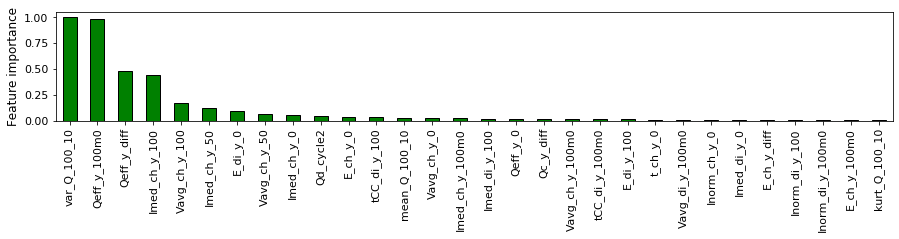

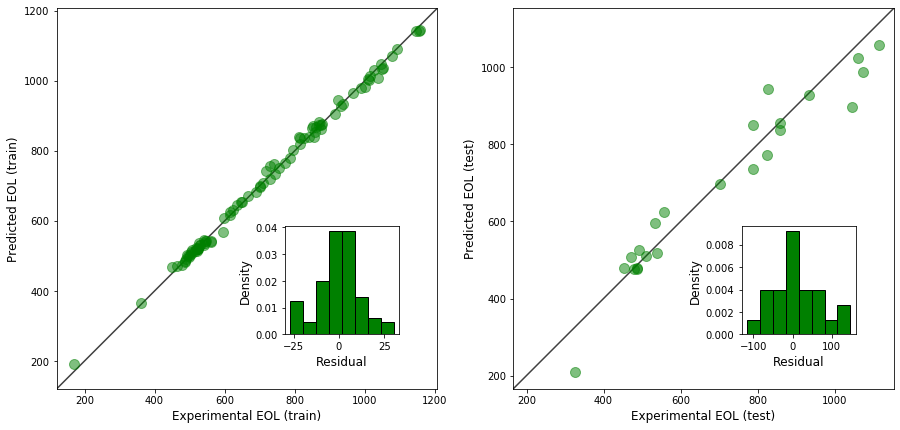

171 features removed from a total of 244
171 features removed from a total of 244
Tree-based regression has started...
Tree-based regression has ended after 0.68 seconds
------------------
Model metrics:
------------------
Train:
{'MAE': 8.709761895073784,
 'MAPE': 0.013407947825114664,
 'MSE': 130.71554215497648,
 'R2 score': 0.9971356597198174,
 'RMSE': 11.43308979038372}
Test:
{'MAE': 46.328960252844766,
 'MAPE': 0.07052161040735698,
 'MSE': 3910.247060976528,
 'R2 score': 0.9285461236718094,
 'RMSE': 62.53196831202843}


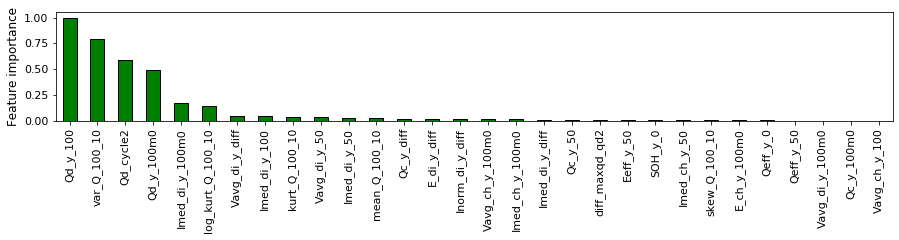

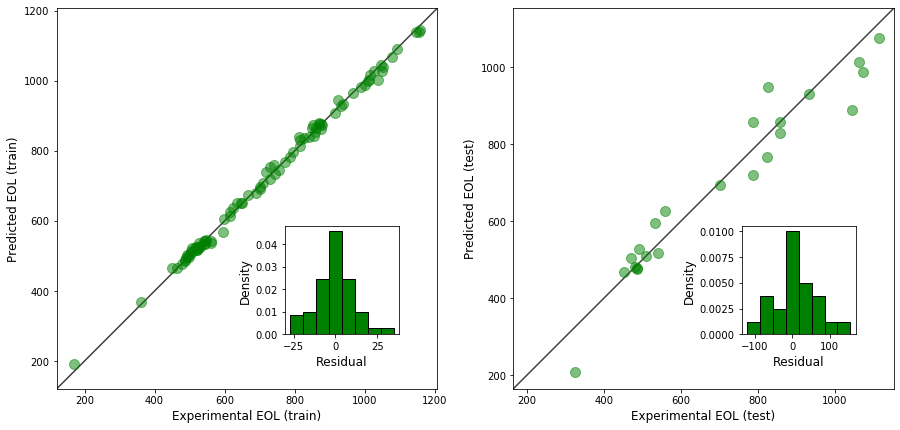

196 features removed from a total of 244
196 features removed from a total of 244
Tree-based regression has started...
Tree-based regression has ended after 0.7 seconds
------------------
Model metrics:
------------------
Train:
{'MAE': 1.5646048651801214,
 'MAPE': 0.002488698692602153,
 'MSE': 4.7236783968828,
 'R2 score': 0.9998964910975409,
 'RMSE': 2.173402493069979}
Test:
{'MAE': 44.995491359544836,
 'MAPE': 0.07010105309562889,
 'MSE': 4220.428689144714,
 'R2 score': 0.922878021540976,
 'RMSE': 64.96482655364142}


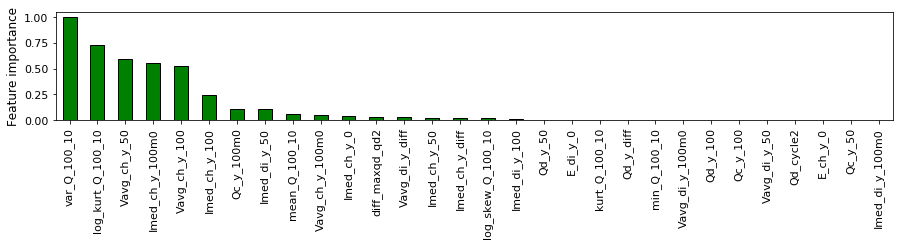

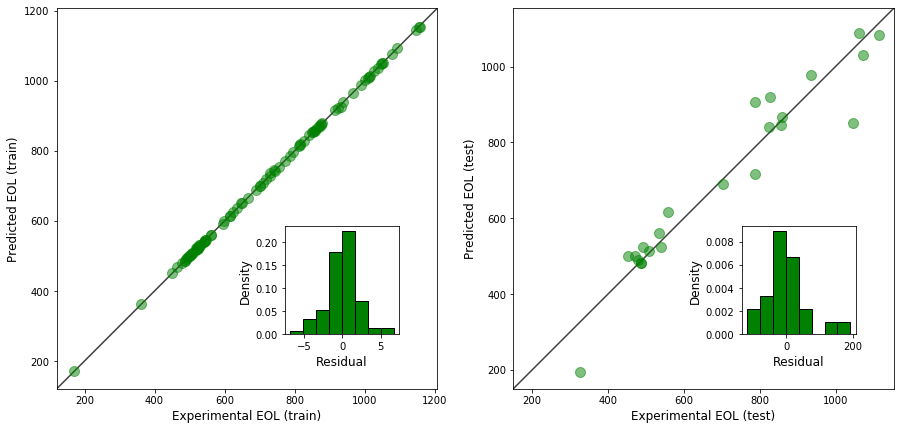

In [46]:
# call the model pipeline function
best_k, best_param, metrics = utils_models.model_pipeline(df=df,
                                                          algo=algo,
                                                          estimator=estimator,
                                                          param_grid=param_grid,
                                                          fname=fname,
                                                          title=title)

In [47]:
best_k

0.6

In [48]:
best_param

{'learning_rate': 0.1,
 'max_depth': 2,
 'min_samples_split': 2,
 'n_estimators': 400}

In [49]:
metrics

,Train_MAE,Train_MAPE,Train_MSE,Train_RMSE,Train_R2 score,Test_MAE,Test_MAPE,Test_MSE,Test_RMSE,Test_R2 score
Features used,,,,,,,,,,
1.0,5.254086,0.008040,45.235585,6.725741,0.999009,54.589687,0.085203,4849.680599,69.639648,0.911379
0.9,6.297146,0.009597,62.784153,7.923645,0.998624,56.443265,0.086766,5428.104586,73.675672,0.900810
0.8,6.627902,0.009805,71.799571,8.473463,0.998427,45.850303,0.070026,3639.701143,60.329936,0.933490
0.7,7.185496,0.010796,87.399593,9.348775,0.998085,49.520066,0.075507,4091.584881,63.965498,0.925232
0.6,0.181960,0.000271,0.052705,0.229576,0.999999,42.307818,0.067088,3213.550744,56.688189,0.941277
0.5,8.212810,0.012413,108.803275,10.430881,0.997616,46.737893,0.071578,4046.344706,63.610885,0.926059
0.4,8.508965,0.012977,127.404126,11.287344,0.997208,44.911855,0.069163,3617.498064,60.145640,0.933896
0.3,8.709762,0.013408,130.715542,11.433090,0.997136,46.328960,0.070522,3910.247061,62.531968,0.928546
0.2,1.564605,0.002489,4.723678,2.173402,0.999896,44.995491,0.070101,4220.428689,64.964827,0.922878


### Perform $k$-Fold Repeated Cross-validation on the model with feature selection and best MAPE

In [50]:
model = XGBRegressor(**best_param)
best_model_cross_val_scores = utils_models.repeated_kfold_cross_validation(model=model,
                                                                            df=df,
                                                                            n_splits=3,
                                                                            n_repeats=3,
                                                                            feature_selection=True,
                                                                            scaling=False,
                                                                            k=best_k)

best_model_cross_val_scores

98 features removed from a total of 244


{'test_MAE': (53.012424826527806, 8.10631390174957),
 'test_MAPE': (0.08345983595494584, 0.024131416980485716),
 'test_RMSE': (71.8263119264027, 11.432031665791897),
 'test_R2 score': (0.8881764435274194, 0.03135855433346822)}